# Onslow et al. 2014

### A Canonical Circuit for Generating Phase-Amplitude Coupling

Replicating the Onslow model, consisting of a set of coupled E-I populations generating theta-nested gamma oscillations. The authors used the Wilson-Cowan formalism. Equations and parameters are given in the paper (Methods, _Description of the model_). 

In [1]:
import os

from brian2 import *

from tqdm.notebook import tqdm
from scipy.signal import welch
from matplotlib import ticker

from ModelFiles.equations import *
from ModelFiles.functions import *
from ModelFiles.global_parameters import *

# Suppress code generation messages on the console
BrianLogger.suppress_name('resolution_conflict')
BrianLogger.suppress_hierarchy('brian2.codegen')

In [2]:
import matplotlib as mplb

# Text parameters
fsize_ticks = fsize_legends = 8
fsize_xylabels = 9
fsize_titles = 10
fsize_figtitles = 11
sizebar_off = 50 # sizebar offset

# Color selection
c_inh = '#bf616a'
c_exc = '#5e81ac'

# ILLUSTRATOR STUFF
mplb.rcParams['pdf.fonttype'] = 42
mplb.rcParams['ps.fonttype'] = 42
mplb.rcParams['axes.titlesize'] = 11
mplb.rcParams['axes.labelsize'] = 9

# Arial font everywhere
# ILLUSTRATOR STUFF
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

In [3]:
# Onslow equations
eqs_onslow = '''
    dE/dt = 1/tau_E * (-E + 1 / (1 + exp(-beta*(gain_E*theta_E + W_EE*E - W_IE*I + g_stim_E*stim_E(t-delay) - xm)))) + sigma_E*sqrt(2/tau_E)*xi_E : 1
    dI/dt = 1/tau_I * (-I + 1 / (1 + exp(-beta*(gain_I*theta_I + W_EI*E - W_II*I + g_stim_I*stim_I(t-delay) - xm)))) + sigma_I*sqrt(2/tau_I)*xi_I : 1
    
    theta_E : 1 (linked)
    theta_I : 1 (linked)
    
    g_stim_E : 1
    g_stim_I : 1
    
    delay : second
'''

# Kuramoto oscillators
eqs_kuramoto = '''
    dTheta/dt = ((omega + (kN * PIF) - gain*X*sin(Theta - pi/2 + offset)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    ThetaPreInput : 1
    omega : 1 (constant)
    kN : 1 (shared)         # k/N ratio, affects sync.
    gain : 1 (shared)       # this is the input gain, affects the phase reset aggressiveness
    offset : 1 (shared)     # range [0, 2*pi], controls phase reset PRC
    X : 1 (linked)          # this is linked to the firing rates
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter group calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    rhythm_pos = coherence * (sin(phase)+1)/2 : 1
    rhythm_simple = rhythm : 1
    rhythm_abs = abs(rhythm) : 1
    rhythm_rect = rhythm_pos : 1
    rhythm_zero = 0*rhythm_rect : 1   # for debugging
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [4]:
# Fixed parameters
seed_val = 42
seed(seed_val)

duration = 3*second
sim_dt = 0.1*ms
stim_dt = 1*ms

# Default simulation dt
defaultclock.dt = sim_dt

# Weights
W_EE = 2*2.4
W_EI = 2*2.
W_IE = 2*2.
W_II = 2*0.

# Gains of inputs
gain_E = 0.7
gain_I = 0.

tau_E = 3.2*ms
tau_I = 3.2*ms

sigma_E = 0.
sigma_I = 0.

xm = 1.
beta = 4.

# Kuramoto oscillators
N_K = 100
sync_K = 25
gain_K = 0
offset_K = 0. #+pi/2.
f0 = 4.
sigma_K = 0.5

# stimulation
S0 = 1
theta_deg = 75
theta = theta_deg*pi/180
tau_stim = 6*ms
t_stim_on = 900*ms
t_stim_off = t_stim_on + 20*stim_dt

# stimulation
#stim_dt = defaultclock.dt
tv = linspace(0, int(duration/ms), int(duration/stim_dt+1))
stim_E_tv = S0*(tv>t_stim_on/ms) - S0*(tv>t_stim_off/ms)
stim_I_tv = S0*(tv>t_stim_on/ms) - S0*(tv>t_stim_off/ms)
stim_E = TimedArray(stim_E_tv, dt=stim_dt)
stim_I = TimedArray(stim_I_tv, dt=stim_dt)

# PR Gain (def. 90)
pr_gain = 90

# PRC calculations
N_sims = 32
delays = linspace(0, 1/f0, N_sims+1)*second

In [5]:
# Make coupled E-I group
G_pop = NeuronGroup(N=1, model=eqs_onslow, method='euler', name='Population')
G_pop.g_stim_E = 1.
G_pop.g_stim_I = 1.

# Make Kuramoto oscillators group
G_kur = NeuronGroup(N=N_K,
                model=eqs_kuramoto,
                threshold='True',
                method='euler',
                name='Kuramoto_oscillators_N_%d' % N_K)
theta0 = 2*pi*rand(N_K) # uniform U~[0,2π]
omega0 = 2*pi*(f0 + sigma_K*randn(N_K)) # ~N(2πf0,σ)
G_kur.Theta = theta0
G_kur.omega = omega0
G_kur.kN = sync_K
G_kur.gain = gain_K
G_kur.offset = offset_K

# Add synapses
syn_kur =  Synapses(G_kur, G_kur, on_pre=syn_kuramoto_eqs, method='euler', name='Kuramoto_intra')
syn_kur.connect(condition='i!=j')

# Kuramoto order parameter group
G_pop_avg = NeuronGroup(1,
                model=pop_avg_eqs,
                #method='euler',
                name='Kuramoto_averaging')
r0 = 1/N_K * sum(exp(1j*G_kur.Theta))
G_pop_avg.x = real(r0)  # avoid division by zero
G_pop_avg.y = imag(r0)
syn_avg = Synapses(G_kur, G_pop_avg, syn_avg_eqs, name='Kuramoto_avg')
syn_avg.connect()

# Link inputs / outputs
G_kur.X = linked_var(G_pop, 'E')
G_pop.theta_E = linked_var(G_pop_avg, 'rhythm_rect') # theta input to E
G_pop.theta_I = linked_var(G_pop_avg, 'rhythm_zero') # no input to I

# Make the state monitors
mon = StateMonitor(G_pop, ['E', 'I'], record=True)
mon_kur = StateMonitor(G_kur, ['Theta'], record=True)
mon_order_param = StateMonitor(G_pop_avg, ['coherence', 'phase', 'rhythm', 'rhythm_rect'], record=True)
monitors_list = [mon, mon_kur, mon_order_param]

# Make a net and store it's state
net = Network()
net.add(G_pop, G_kur, G_pop_avg)
net.add(syn_kur, syn_avg)
net.add(monitors_list)
net.store('initialized')

In [6]:
# Restore network state
net.restore('initialized')

# Set the gain variable on the Kuramoto group
G_kur.gain = pr_gain

# Run a simulation with E-stimulation
G_pop.g_stim_E = 1.
G_pop.g_stim_I = 0.
G_pop.delay = 0*second

# Run a simulation
net.run(duration)

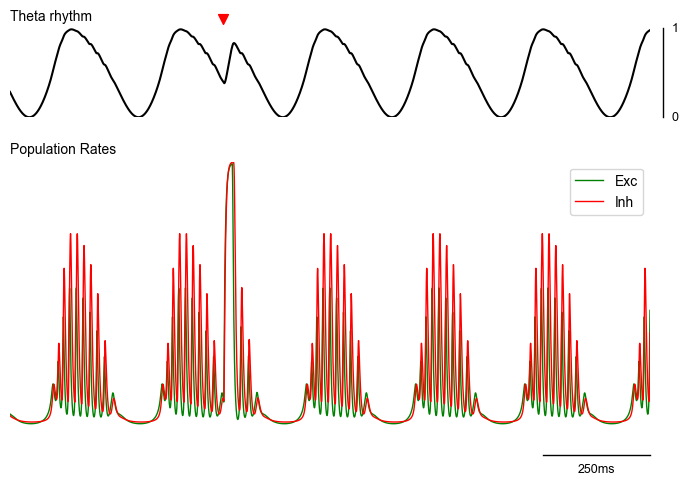

In [7]:
xlims_rhythm = [0.4, 1.9]

# Make a figure
fig = plt.figure(figsize=(8,5))

# Use gridspec
gs = fig.add_gridspec(2,1, height_ratios=(1,3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      hspace=0.25)

# Create the axes
ax_rhythm = fig.add_subplot(gs[0])
ax_onslow = fig.add_subplot(gs[1])

# Plot the subplot figure
ax_rhythm.plot(mon_order_param.t/second, mon_order_param.rhythm_rect[0], color='k', label='Theta rhythm')
ax_onslow.plot(mon.t/second, mon.E[0], color='g', linewidth=1, label='Exc')
ax_onslow.plot(mon.t/second, mon.I[0], color='r', linewidth=1, label='Inh')

# Indicate stimulation
# ax_rhythm.axvline(x=t_stim_on/second, ymin=-1, ymax=3, c="red", linewidth=1, zorder=-1)
# ax_onslow.axvline(x=t_stim_on/second, ymin=-1, ymax=3, c="red", linewidth=1, zorder=-1)
ax_rhythm.scatter(t_stim_on/second, 1.1, c='red', marker='v', clip_on=False, s=50)


# Add the labels
# ax_onslow.set_ylabel('Gain = {0}'.format(pr_gain), fontsize=10)
# ax_onslow.set_xlabel('Time [s]', fontsize=10)

# Fixed tick locators
ax_onslow.set_xticks(np.arange(0, 2.5, 0.5))

# Set the xlims/ylims
ax_rhythm.set_xlim(xlims_rhythm)
ax_onslow.set_xlim(xlims_rhythm)
ax_rhythm.set_ylim([0, 1])
ax_onslow.set_ylim([0, 1])


# Remove the box borders
ax_rhythm.spines['top'].set_visible(False)
ax_rhythm.spines['right'].set_visible(False)
ax_rhythm.spines['bottom'].set_visible(False)
ax_rhythm.spines['left'].set_visible(False)

ax_onslow.spines['top'].set_visible(False)
ax_onslow.spines['right'].set_visible(False)
ax_onslow.spines['bottom'].set_visible(False)
ax_onslow.spines['left'].set_visible(False)

# Remove ticks
ax_rhythm.get_xaxis().set_ticks([])
ax_rhythm.get_yaxis().set_ticks([])
ax_onslow.get_xaxis().set_ticks([])
ax_onslow.get_yaxis().set_ticks([])

# Titles
ax_rhythm.set_title('Theta rhythm', loc='left', fontsize=fsize_titles)
ax_onslow.set_title('Population Rates', loc='left', fontsize=fsize_titles)

# Add sizebars
add_sizebar(ax_rhythm, [xlims_rhythm[1]+0.03, xlims_rhythm[1]+0.03], [0, 1], 'black', ['0', '1'], fsize=9, rot=[0, 0], 
            textx=[xlims_rhythm[1]+0.05]*2, texty=[0, 1], 
            ha='left', va='center')

add_sizebar(ax_onslow, [xlims_rhythm[1]-0.25, xlims_rhythm[1]-0.], [-0.1, -0.1], 'black', '250ms', fsize=9, rot=0, 
            textx=np.mean([xlims_rhythm[1]-0.25, xlims_rhythm[1]-0.]), texty=-0.13, 
            ha='center', va='top')




# Add the legends
ax_onslow.legend()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels)


# Show the figure
plt.show()

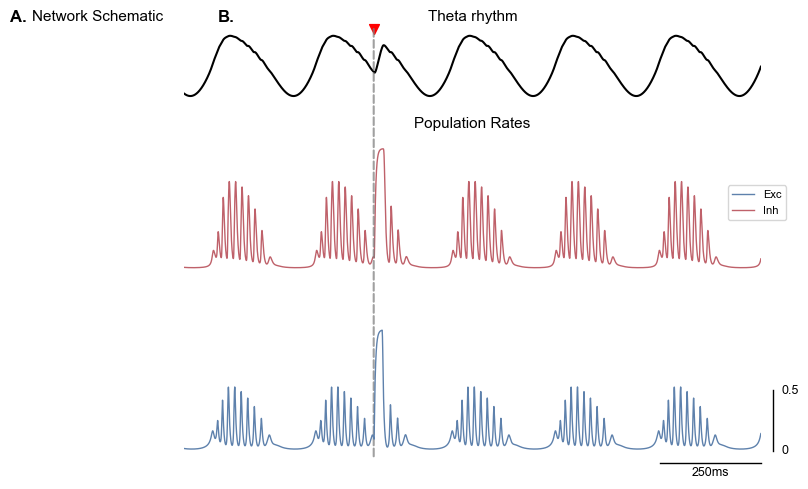

In [37]:
from matplotlib.patches import ConnectionPatch

""" Fixed parameters to affect fontsizes """
fsize_ticks = fsize_legends = 8
fsize_xylabels = 9
fsize_misc = 10
fsize_titles = 11
fsize_panels = 12


xlims_rhythm = [0.43, 1.86]
ylims_all = [-0.1, 1.1]

# Make a figure
fig = plt.figure(figsize=(8,5))

# Use gridspec
gs = fig.add_gridspec(3,2, height_ratios=(1,2,2),
                      left=0.15, right=0.975, bottom=0.01, top=0.99,
                      width_ratios=(0.2, 0.8),
                      # hspace=0.15,
                      wspace=0.2)

# Create the axes
ax_placeholder = fig.add_subplot(gs[:,0])
ax_rhythm = fig.add_subplot(gs[0,1])
ax_onslow_I = fig.add_subplot(gs[1,1])
ax_onslow_E = fig.add_subplot(gs[2,1])

# Plot the subplot figure
ax_rhythm.plot(mon_order_param.t/second, mon_order_param.rhythm_rect[0], color='k', label='Theta rhythm')
ax_onslow_E.plot(mon.t/second, mon.E[0], color=c_exc, linewidth=1, label='Exc')
ax_onslow_I.plot(mon.t/second, mon.I[0], color=c_inh, linewidth=1, label='Inh')

# Indicate stimulation
# ax_rhythm.axvline(x=t_stim_on/second, ymin=-1, ymax=3, c="red", linewidth=1, zorder=-1)
# ax_onslow.axvline(x=t_stim_on/second, ymin=-1, ymax=3, c="red", linewidth=1, zorder=-1)
ax_rhythm.scatter(t_stim_on/second, 1.1, c='red', marker='v', clip_on=False, s=50)
# ax_rhythm.vlines(x=t_stim_on/second, ymin=-19.6, ymax=1., color='gray', alpha=0.75, ls='--', linewidth=1.5, zorder=101, rasterized=False, clip_on=False)
con = ConnectionPatch(xyA=(t_stim_on/second, 1.1), xyB=(t_stim_on/second, -0.05), coordsA="data", coordsB="data",
                      axesA=ax_rhythm, axesB=ax_onslow_E, linestyle='--', linewidth=1.5, color='gray', alpha=0.75)
ax_onslow_E.add_artist(con)

# Add the labels
# ax_onslow.set_ylabel('Gain = {0}'.format(pr_gain), fontsize=10)
# ax_onslow.set_xlabel('Time [s]', fontsize=10)

# Fixed tick locators
ax_onslow.set_xticks(np.arange(0, 2.5, 0.5))

# Set the xlims/ylims
ax_rhythm.set_xlim(xlims_rhythm)
ax_rhythm.set_ylim(ylims_all)
ax_onslow_E.set_xlim(xlims_rhythm)
ax_onslow_E.set_ylim(ylims_all)
ax_onslow_I.set_xlim(xlims_rhythm)
ax_onslow_I.set_ylim(ylims_all)

# Remove the box borders
ax_placeholder.spines['top'].set_visible(False)
ax_placeholder.spines['right'].set_visible(False)
ax_placeholder.spines['bottom'].set_visible(False)
ax_placeholder.spines['left'].set_visible(False)

ax_rhythm.spines['top'].set_visible(False)
ax_rhythm.spines['right'].set_visible(False)
ax_rhythm.spines['bottom'].set_visible(False)
ax_rhythm.spines['left'].set_visible(False)

ax_onslow_E.spines['top'].set_visible(False)
ax_onslow_E.spines['right'].set_visible(False)
ax_onslow_E.spines['bottom'].set_visible(False)
ax_onslow_E.spines['left'].set_visible(False)

ax_onslow_I.spines['top'].set_visible(False)
ax_onslow_I.spines['right'].set_visible(False)
ax_onslow_I.spines['bottom'].set_visible(False)
ax_onslow_I.spines['left'].set_visible(False)

# Remove ticks
ax_placeholder.get_xaxis().set_ticks([])
ax_placeholder.get_yaxis().set_ticks([])
ax_rhythm.get_xaxis().set_ticks([])
ax_rhythm.get_yaxis().set_ticks([])
ax_onslow_E.get_xaxis().set_ticks([])
ax_onslow_E.get_yaxis().set_ticks([])
ax_onslow_I.get_xaxis().set_ticks([])
ax_onslow_I.get_yaxis().set_ticks([])

# Titles
ax_placeholder.set_title('Network Schematic', loc='center', fontsize=fsize_titles)
ax_rhythm.set_title('Theta rhythm', loc='center', fontsize=fsize_titles)
ax_onslow_I.set_title('Population Rates', loc='center', fontsize=fsize_titles)

# Add sizebars
add_sizebar(ax_onslow_E, [xlims_rhythm[1]+0.03, xlims_rhythm[1]+0.03], [0, 0.5], 'black', ['0', '0.5'], fsize=9, rot=[0, 0], 
            textx=[xlims_rhythm[1]+0.05]*2, texty=[0, 0.5], 
            ha='left', va='center')

add_sizebar(ax_onslow_E, [xlims_rhythm[1]-0.25, xlims_rhythm[1]-0.], [-0.1, -0.1], 'black', '250ms', fsize=9, rot=0, 
            textx=np.mean([xlims_rhythm[1]-0.25, xlims_rhythm[1]-0.]), texty=-0.13, 
            ha='center', va='top')

# Panels text
fig.text(0.0, 0.946, 'A.', weight='bold', fontsize=fsize_panels)
fig.text(0.26, 0.946, 'B.', weight='bold', fontsize=fsize_panels)

# Add the legend
handles_all = []
labels_all = []
for ax in [ax_onslow_E, ax_onslow_I]:
    handles, labels = ax.get_legend_handles_labels()
    handles_all += handles
    labels_all += labels
# ax_onslow_I.legend(handles_all, labels_all, loc='best')
fig.legend(handles_all, labels_all, loc=[0.9, 0.55], fontsize=fsize_legends)

# Tight layout
gs.tight_layout(fig)

# Save the figure
fig.savefig("PR_Onslow_rev_eLife.png")
fig.savefig("PR_Onslow_rev_eLife.pdf")

# Show the figure
plt.show()